dataset: https://www.kaggle.com/andyczhao/covidx-cxr2?select=train.txt

In [1]:
#importing the libraries
import pandas as pd
import os
import numpy as np
import time
import copy
import warnings
from tqdm import tqdm

#for reading and displaying images
import matplotlib.pyplot as plt
from PIL import Image
import cv2

#Pytorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split

#torchvision for pre-trained models and augmentation
import torchvision
import torchvision.transforms as transforms
from torchvision import models

#for evaluating model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

In [2]:
#tao duong dan den data
train_path = '../dataset/train/'
test_path = '../dataset/test/'

In [3]:
#doc file metadata
train_metadata = '../dataset/' + 'train.txt'
test_metadata = '../dataset/' + 'test.txt'
train_txt= pd.read_csv(train_metadata, sep=" ", header=None)
test_txt = pd.read_csv(test_metadata, sep=" ", header=None)

In [4]:
#gan ten cot
train_txt.columns= ["patient id","file_name","class","source"]
train_txt.head()

,patient id,file_name,class,source
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen


In [5]:
#https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
train_txt['label'] = np.where(train_txt['class']== 'negative', 0, 1) #tao cot label theo dk cua class
train_txt

,patient id,file_name,class,source,label
0,5,ARDSSevere.png,negative,cohen,0
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen,0
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen,0
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen,0
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen,0
...,...,...,...,...,...
30477,55204bb8-89fc-449d-8563-e91654abea9d,55204bb8-89fc-449d-8563-e91654abea9d.png,negative,rnsa,0
30478,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,negative,rnsa,0
30479,5fb64e85-62ef-4852-8ad1-f799015c8cc3,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,negative,rnsa,0
30480,c57ad4fd-3aa8-4ae8-a262-7336360d8265,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,negative,rnsa,0


In [6]:
#chi lay cot filename va label (1,4)
train_txt1 = train_txt.iloc[:,[1,4]]
train_txt1

,file_name,label
0,ARDSSevere.png,0
1,acute-respiratory-distress-syndrome-ards-1.jpg,0
2,acute-respiratory-distress-syndrome-ards.jpg,0
3,ards-secondary-to-tiger-snake-bite.png,0
4,pneumocystis-pneumonia-2-PA.png,0
...,...,...
30477,55204bb8-89fc-449d-8563-e91654abea9d.png,0
30478,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,0
30479,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,0
30480,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,0


In [7]:
#gan ten cot tren file test
test_txt.columns= ["patient id","file_name","class","source"]
test_txt.head()

,patient id,file_name,class,source
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [8]:
test_txt['label'] = np.where(test_txt['class']== 'negative', 0, 1) #tao cot label theo dk cua class
test_txt

,patient id,file_name,class,source,label
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord,1
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord,1
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord,1
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord,1
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord,1
...,...,...,...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,negative,rsna,0
396,41bf2042-53a2-44a8-9a29-55e643af5ac0,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,negative,rsna,0
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,negative,rsna,0
398,abff4044-3c0a-458f-b0c7-04254be7fc0c,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,negative,rsna,0


In [9]:
#chi lay cot filename va label (1,4)
test_txt1 = test_txt.iloc[:,[1,4]]
test_txt1

,file_name,label
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,1
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,1
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,1
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,1
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,1
...,...,...
395,a77b32f6-1999-4cc6-8a0d-1ef7e53850f0.png,0
396,41bf2042-53a2-44a8-9a29-55e643af5ac0.png,0
397,ec09ddb3-9b0b-4749-9e0d-f94a4a7e5fed.png,0
398,abff4044-3c0a-458f-b0c7-04254be7fc0c.png,0


In [10]:
train_set,val_set=train_test_split(train_txt1,test_size=0.2, random_state = 42, shuffle=True)

In [11]:
train_set

,file_name,label
11830,46c06db4-948e-4495-a9a1-d4f945a0fb6e.png,0
1192,COVID(487).png,1
13999,b1f2db42-68ac-4c11-a4f4-3f6b8b6be999.png,0
24485,A806933-01-03-1901-NA-CHEST_AP_PORT-36564-2.00...,1
13369,9e149c3a-0dbc-4d4d-a7f6-939c4e4d8688.png,0
...,...,...
29802,A609098-11-26-1900-NA-CHEST_AP_PORT-52751-1.00...,1
5390,7462adfa-a0fc-4489-8d58-89f1d012c26a.png,0
860,COVID(151).png,1
15795,1ffee791-10f6-4b8f-bfcd-35220e8e0003.png,0


In [12]:
val_set

,file_name,label
13643,a8b5a123-6dbd-412e-a871-12f4f65a6a05.png,0
23656,A765481-01-01-1901-NA-CHEST_AP_PORT_CENTRAL_LI...,1
15264,e8659775-8a7f-40c1-a3a9-abdc85ba4fd4.png,0
21658,A923527-01-17-1901-NA-CHEST_AP_PORT_CENTRAL_LI...,1
28506,A586701-12-31-1900-NA-CHEST_AP_VIEWONLY-67467-...,1
...,...,...
25374,A003797-01-09-1901-NA-CHEST_AP_PORT-58101-2.00...,1
7785,b5c901dc-9e41-4ffd-b880-412e0f9b8ef9.png,0
19887,A142433-12-21-1900-NA-CHEST_AP_PORT-69348-4.00...,1
11034,29576186-ed47-4331-8ea0-08d899822c1f.png,0


In [13]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24385 entries, 11830 to 23654
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  24385 non-null  object
 1   label      24385 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 571.5+ KB


In [14]:
BATCH_SIZE = 32
classes = ['Negative', 'Positive']

feature_extract = False
lr = 1e-3
num_classes = 2
num_epochs = 15
criterion = CrossEntropyLoss()
CHECKPOINT_PATH = '../model/FT_VGG16bn_cp.pt'

std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
#https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
class ImageDataset(Dataset):
    def __init__(self,csv,img_folder,transform): # 'Initialization'
        self.csv=csv
        self.transform=transform
        self.img_folder=img_folder
    
        self.image_names=self.csv[:]['file_name']# [:] lấy hết số cột số hàng của bảng
        self.labels= np.array(self.csv[:]['label']) # note kiểu mảng int đúng không?
  
    def __len__(self):  # 'Denotes the total number of samples'
        return len(self.image_names)

    def __getitem__(self,index): # 'Generates one sample of data'
    
        image=Image.open(self.img_folder + self.image_names.iloc[index]).convert('RGB')
#         print('image',image)

        image=self.transform(image)
#         image.Resize((224,224))
        targets=self.labels[index]
        targets = torch.tensor(targets, dtype=torch.long) #đọc từng phần tử của mảng, chuyển từ array -> tensor; kiểu int64 tương ứng với long trong pytorch

        return image, targets # chua 1 cap

In [16]:
train_transform = transforms.Compose([
    transforms.Resize((360, 360)),
    transforms.RandomAffine(degrees = 0, shear = 0.2),
    transforms.CenterCrop(310),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform =transforms.Compose([
    transforms.Resize((360, 360)),
    transforms.CenterCrop(310),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset=ImageDataset(train_set,train_path,train_transform)
val_dataset=ImageDataset(val_set,train_path,test_transform) ############
test_dataset=ImageDataset(test_txt,test_path,test_transform)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size= BATCH_SIZE,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataloader_dict = {'train': train_dataloader,
                  'val': val_dataloader,
                  'test':test_dataloader}

torch.Size([32, 3, 224, 224])


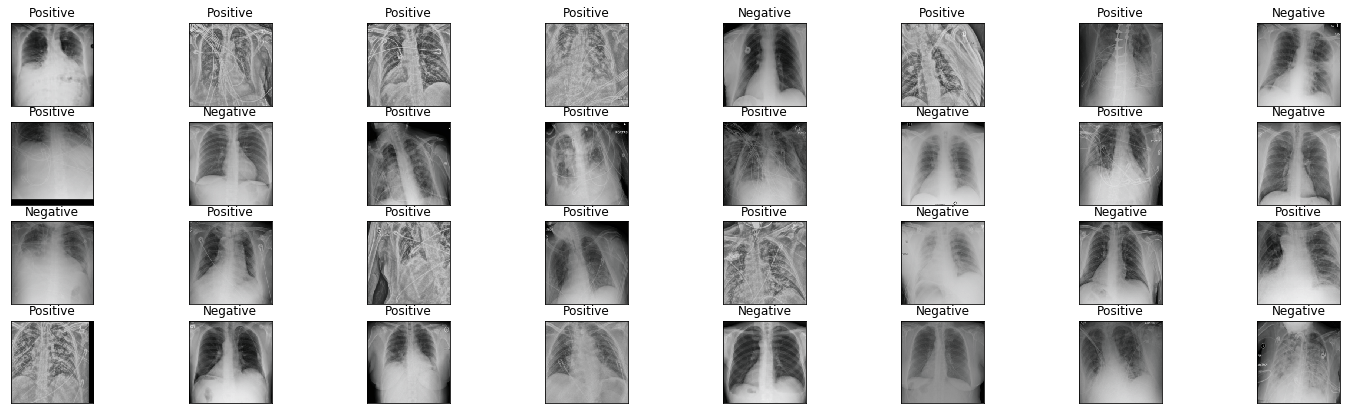

In [17]:
def imshow(inp, title=None):
    """imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    
# Get a batch of training data
image, label = next(iter(train_dataloader))
fig = plt.figure(figsize=(25, 7))
print(image.size())

# display batch_size = 40 images
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, BATCH_SIZE/4, idx+1, xticks=[], yticks=[])
    imshow(image[idx]) # lay 1 cap co nghia la o day show anh
    ax.set_title(classes[label[idx]]) # vì đã chuyển từ nes/pos -> 0,1 -> tensor 0,1

# Define  Train the Model using Early Stopping

In [18]:
def training_loop(model, optimizer, loss_list, acc_list):
    model.to(device)
    #List to store loss to visualize
    lossli = loss_list
    accli = acc_list
    
    y_true = []
    y_pred = []
    
    valid_loss_min = np.Inf # track change in validation loss
    count = 0
    patience = 8 # nếu val_loss tăng 8 lần thì ngừng
    for epoch in range(num_epochs):
        
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for data, label in tqdm(train_dataloader):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        
            
            train_loss += loss.item()*data.size(0)
            
            _, pred = torch.max(output, 1)              
            
            train_acc += pred.eq(label).sum().item()
            
#         scheduler.step() ###########
            
        ######################
        # validate the model #
        ######################
        
        model.eval()
        with torch.no_grad():
            for data, label in tqdm(val_dataloader):
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item()*data.size(0)
                
                # Calculate accuracy
                _, pred = torch.max(output, 1)
#                 y_true += target.tolist()
#                 y_pred += pred.tolist()  
                
                valid_acc +=  pred.eq(label).sum().item()
       
        # calculate average losses
        train_loss = train_loss/len(train_dataloader.dataset)
        valid_loss = valid_loss/len(val_dataloader.dataset)
        lossli.append({'epoch':epoch,'train_loss': train_loss,'valid_loss':valid_loss})
        
        train_acc = train_acc*100/len(train_dataloader.dataset)
        valid_acc = valid_acc*100/len(val_dataloader.dataset)
        accli.append({'epoch':epoch,'train_acc': train_acc,'valid_acc':valid_acc})
        
        ####################
        # Early stopping #
        ##################
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc))
        # save model if validation loss has decreased
       
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': accli,
            'loss_list': lossli,
            'loss': loss
            }, CHECKPOINT_PATH)
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            
            count = 0
            print('count = ',count)
            torch.save(model, '../model/FTVGG16_modelpp.pt') #save model 
                                  
            valid_loss_min = valid_loss
        else:
            count += 1
            print('count = ',count)
            if count >= patience:
                print('Early stopping!')
   
                return lossli, accli    
           
    return lossli, accli

# Transfer Learning

In [19]:
# def set_parameter_requires_grad (model, feature_extracting):
#     if feature_extracting:
#         for param in model.parameters():
#             param.requires_grad = False

In [20]:
# def initialize_model(num_classes, feature_extract, use_pretrained = True):
#     model_ft = models.vgg16(pretrained = use_pretrained)
#     set_parameter_requires_grad(model_ft, feature_extract)
#     num_ftrs = model_ft.classifier[6]???.in_features
#     model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
#     input_size = 224
    
#     model_ft.avgpool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
#     numFeatures = model_ft.classifier[0].in_features
#     # loop over the modules of the model and set the parameters of
#     # batch normalization modules as not trainable
#     for module, param in zip(model_ft.modules(), model_ft.parameters()):
#     #kiểm tra xem môt đối tượng (tham số thứ nhất) là một instance hay là một lớp con của tham số thứ hai.
#         if isinstance(module, nn.BatchNorm2d): 
#             param.requires_grad = False
#     # define the network head and attach it to the model
#     headModel = nn.Sequential(
#         nn.Linear(8192, 128),
#         nn.ReLU(),
#         nn.Linear(128, 64),
#         nn.ReLU(),
#         nn.Dropout(0.5),
#         nn.Linear(64, num_classes)
#     )
#     model_ft.classifier = headModel 
#     return model_ft, input_size

# # Initialize the model for this run
# model_ft, input_size = initialize_model(num_classes, feature_extract = False, use_pretrained = True)

# print (model_ft)

In [21]:
# # Send the model to GPU
# model_ft = model_ft.to(device)

# # Gather the parameters to be optimized/updated in this run. If we are
# #  finetuning we will be updating all parameters. However, if we are
# #  doing feature extract method, we will only update the parameters
# #  that we have just initialized, i.e. the parameters with requires_grad
# #  is True.
# params_to_update = model_ft.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# # Observe that all parameters are being optimized
# optimizer = Adam(params_to_update ,lr = lr, weight_decay = lr/num_epochs)


In [22]:
# loading the pretrained model
model_ft = models.vgg19_bn(pretrained = True)
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False 
model_ft.classifier[6] = Linear(4096, num_classes)
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train the Model

In [24]:
loss_list, acc_list = [],[]
optimizer = Adam(model_ft.parameters(), lr = 0.001, weight_decay=1e-5)

since = time.time()

loss, acc = training_loop(
    model = model_ft,
    optimizer = optimizer,
    loss_list = loss_list,
    acc_list = acc_list
)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

100%|██████████| 191/191 [01:34<00:00,  2.02it/s]


Epoch: 0 	Training Loss: 0.316436 	Validation Loss: 0.227795 
 	Training Acc: 87.828583 	Validation Acc: 92.865344
Validation loss decreased (inf --> 0.227795). Saving model ...
count =  0


100%|██████████| 191/191 [01:33<00:00,  2.05it/s]


Epoch: 1 	Training Loss: 0.210785 	Validation Loss: 0.220511 
 	Training Acc: 92.483084 	Validation Acc: 90.683943
Validation loss decreased (0.227795 --> 0.220511). Saving model ...
count =  0


100%|██████████| 191/191 [01:34<00:00,  2.03it/s]


Epoch: 2 	Training Loss: 0.212720 	Validation Loss: 0.550496 
 	Training Acc: 92.757843 	Validation Acc: 78.858455


  0%|          | 0/763 [00:00<?, ?it/s]

count =  1


100%|██████████| 191/191 [01:34<00:00,  2.02it/s]


Epoch: 3 	Training Loss: 0.244004 	Validation Loss: 1.224879 
 	Training Acc: 92.241132 	Validation Acc: 81.581105


  0%|          | 0/763 [00:00<?, ?it/s]

count =  2


100%|██████████| 191/191 [01:34<00:00,  2.01it/s]


Epoch: 4 	Training Loss: 0.596041 	Validation Loss: 0.999480 
 	Training Acc: 81.500923 	Validation Acc: 56.437592


  0%|          | 0/763 [00:00<?, ?it/s]

count =  3


100%|██████████| 191/191 [01:33<00:00,  2.04it/s]


Epoch: 5 	Training Loss: 0.352128 	Validation Loss: 0.763088 
 	Training Acc: 87.496412 	Validation Acc: 67.607020


  0%|          | 0/763 [00:00<?, ?it/s]

count =  4


100%|██████████| 191/191 [01:32<00:00,  2.06it/s]


Epoch: 6 	Training Loss: 0.252188 	Validation Loss: 0.388651 
 	Training Acc: 90.978060 	Validation Acc: 82.975234


  0%|          | 0/763 [00:00<?, ?it/s]

count =  5


100%|██████████| 191/191 [01:36<00:00,  1.98it/s]


Epoch: 7 	Training Loss: 0.296334 	Validation Loss: 0.936764 
 	Training Acc: 88.492926 	Validation Acc: 69.132360


  0%|          | 0/763 [00:00<?, ?it/s]

count =  6


100%|██████████| 191/191 [01:36<00:00,  1.97it/s]


Epoch: 8 	Training Loss: 0.263482 	Validation Loss: 0.168364 
 	Training Acc: 89.682182 	Validation Acc: 93.800230
Validation loss decreased (0.220511 --> 0.168364). Saving model ...
count =  0


100%|██████████| 191/191 [01:36<00:00,  1.98it/s]


Epoch: 9 	Training Loss: 0.243306 	Validation Loss: 0.143827 
 	Training Acc: 92.109904 	Validation Acc: 94.439888
Validation loss decreased (0.168364 --> 0.143827). Saving model ...
count =  0


100%|██████████| 191/191 [01:36<00:00,  1.99it/s]


Epoch: 10 	Training Loss: 0.190190 	Validation Loss: 0.150752 
 	Training Acc: 92.991593 	Validation Acc: 94.571101


  0%|          | 0/763 [00:00<?, ?it/s]

count =  1


100%|██████████| 191/191 [01:35<00:00,  2.00it/s]


Epoch: 11 	Training Loss: 0.185113 	Validation Loss: 0.127863 
 	Training Acc: 93.295058 	Validation Acc: 95.112350
Validation loss decreased (0.143827 --> 0.127863). Saving model ...
count =  0


100%|██████████| 191/191 [01:37<00:00,  1.95it/s]


Epoch: 12 	Training Loss: 0.179053 	Validation Loss: 0.135969 
 	Training Acc: 93.344269 	Validation Acc: 95.177956


  0%|          | 0/763 [00:00<?, ?it/s]

count =  1


100%|██████████| 191/191 [01:37<00:00,  1.97it/s]


Epoch: 13 	Training Loss: 0.188297 	Validation Loss: 0.145960 
 	Training Acc: 92.864466 	Validation Acc: 95.079547


  0%|          | 0/763 [00:00<?, ?it/s]

count =  2


100%|██████████| 191/191 [01:33<00:00,  2.04it/s]


Epoch: 14 	Training Loss: 0.157556 	Validation Loss: 1.279790 
 	Training Acc: 94.467911 	Validation Acc: 60.783992
count =  3
Training complete in 151m 9s


# load model, state_dict

In [25]:
checkpoint = torch.load(CHECKPOINT_PATH)#, map_location=device)
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_list = checkpoint['loss_list']
acc_list = checkpoint['train_acc']

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


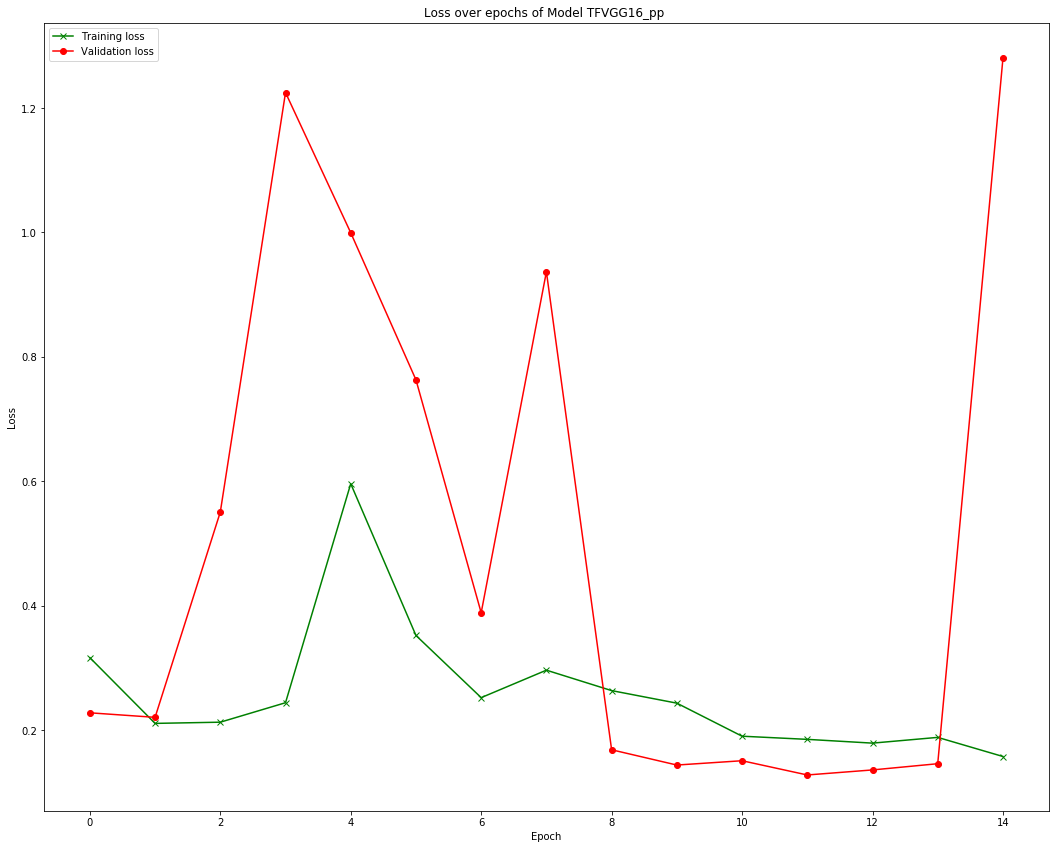

In [26]:
#ve do thi loss (train, val)
def visualize_loss (checkpoint, path_loss):
    loss = checkpoint['loss_list'] 
    train_loss = [x['train_loss'] for x in loss]
    valid_loss = [x['valid_loss'] for x in loss]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_loss, '-gx', label='Training loss')
    ax.plot(valid_loss , '-ro', label='Validation loss')
    ax.set(title="Loss over epochs of Model TFVGG16_pp ",
    xlabel='Epoch',
    ylabel='Loss')
    ax.legend()
    fig.show()
    plt.savefig(path_loss)
visualize_loss(checkpoint, '../report/lossTFVGG16_pp.png')

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


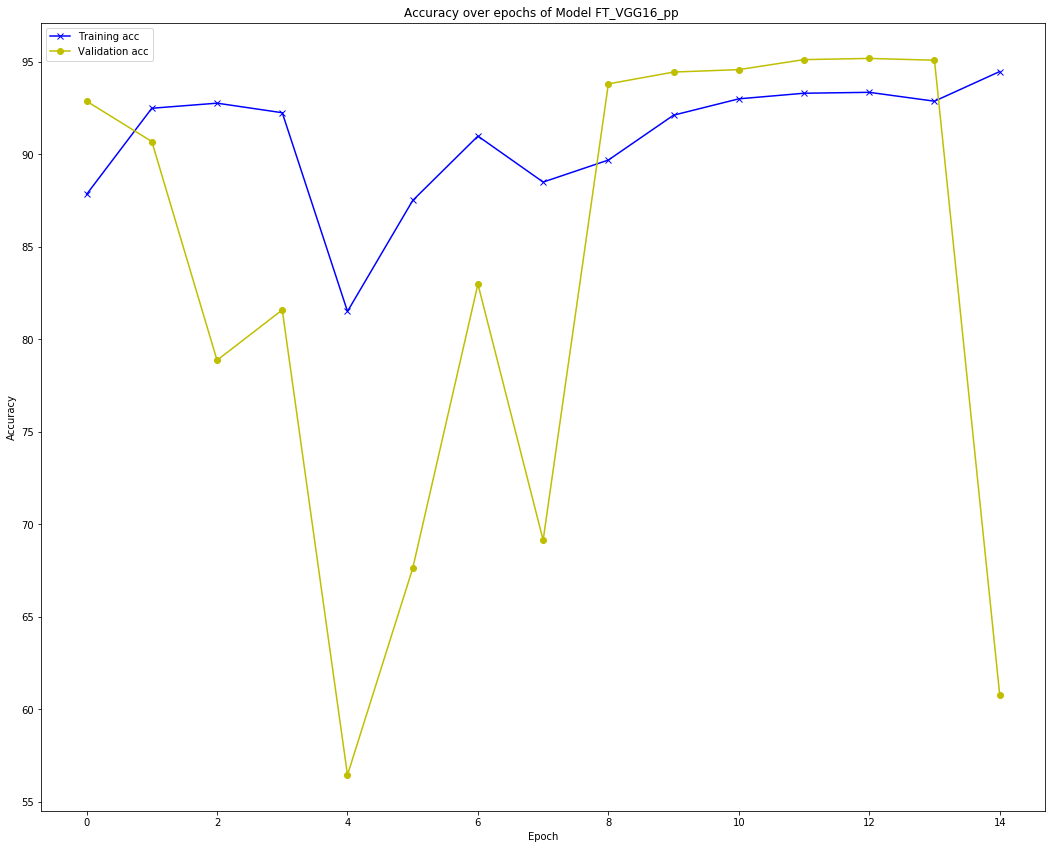

In [27]:
#ve do thi acc (train, val)
def visualize_acc (checkpoint, path_acc):
    acclist = checkpoint['train_acc'] #
    train_acc = [x['train_acc'] for x in acclist]
    valid_acc = [x['valid_acc'] for x in acclist]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_acc, '-bx', label='Training acc')
    ax.plot(valid_acc , '-yo', label='Validation acc')
    ax.set(title="Accuracy over epochs of Model FT_VGG16_pp ",
    xlabel='Epoch',
    ylabel='Accuracy')
    ax.legend()
    fig.show()
    plt.savefig(path_acc)
visualize_acc(checkpoint, '../report/AccuracyFTVGG16_pp.png')

In [28]:
#test model
def test_loop():
    with torch.no_grad():
        y_true = []
        y_pred = []
        model_ft.to(device)
        model_ft.eval()
        for data, target in test_dataloader:
            batch_size = data.size(0)
            data = data.to(device)
            target = target.to(device)
            output = model_ft(data)
            _,pred = torch.max(output, 1)
            y_true += target.tolist()
            y_pred += pred.tolist()
    return y_true, y_pred


y_true, y_pred = test_loop()
        

In [29]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.565

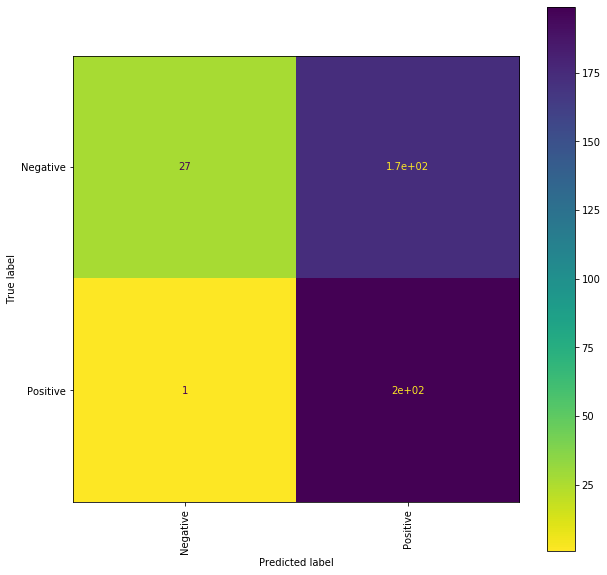

In [30]:
cnf_matrix = confusion_matrix(y_true, y_pred)
fix, ax = plt.subplots(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = classes)
disp.plot(include_values = True, cmap = 'viridis_r', ax = ax, xticks_rotation = 'vertical')
plt.savefig('../report/Matrix.png')

In [31]:
path_rp = '../report/reportVGG16.txt'
try:
    s = classification_report(y_true, y_pred, target_names = classes)
    with open(path_rp, mode ='x') as f:
        f.write(s)
    with open(path_rp) as f:
        print(f.read())
    f.close()
except FileExistsError:
    pass

In [32]:
# Predict images
def img_transform(path_img):
    img = Image.open(path_img)
    imagetensor = transform(img).cuda()
    return imagetensor

def predict(path_img, verbose = False):
    if not verbose:
        warnings.filterwarnings('ignore')
    try:
        checks_if_model_is_loaded = type(model)
    except:
        pass
    model_ft.eval()
    if verbose:
        print('Model loader ...')
    image = img_transform(path_img)
    image1 = image[None,:,:,:]
    
    with torch.no_grad():
        outputs = model_ft(image1)
        
        _,pred_int = torch.max(outputs.data, 1)
        _,top1_idx = torch.topk(outputs.data, 1, dim = 1)
        pred_idx = int(pred_int.cpu().numpy())
        if pred_idx == 0:
            pred_str = str('Negative')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
        else:
            pred_str = str('Positive')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
            
    

In [ ]:
pred_str = str('')
path_image = './pred/covid.jpg'

img = Image.open(path_image)
plt.imshow(img)

predict(path_image)
plt.title('predict:{}'.format(pred_str))
plt.text(5,45,'top {}:{}'.format(1,pred_str), bbox = dict(fc='yellow'))
plt.show()